In [6]:
# Cell 1: dynamics, controllers, and simulations
import numpy as np
# Note: matplotlib/scipy imports not required here; plotting cells import matplotlib separately.

# Physical parameters (tuned to be realistic for a ~1.5 kg quadcopter)
m = 1.5                      # kg
g = 9.80665                  # m/s^2
l = 0.17                     # arm length (m)
kf = 2.34e-5                 # thrust coefficient N/(rad/s)^2 (tuned so ~3.75 N @ 400 rad/s)
km = 1.0e-6                  # yaw moment coefficient
Ixx = 0.02; Iyy = 0.02; Izz = 0.04
I = np.diag([Ixx, Iyy, Izz]); invI = np.linalg.inv(I)
max_omega = 700.0            # rad/s

# Allocation matrix and pseudo-inverse
A = np.array([
    [kf,    kf,    kf,    kf],
    [0,    -l*kf,  0,     l*kf],
    [-l*kf, 0,     l*kf,  0],
    [km,   -km,    km,   -km]
])
A_inv = np.linalg.pinv(A)

def omegas_from_forces_moments(T, tau):
    # map desired total thrust (T) and body torques (tau) to rotor speeds
    b = np.hstack(([T], tau))
    w2 = A_inv.dot(b)
    w2 = np.nan_to_num(w2, nan=0.0, posinf=max_omega**2, neginf=0.0)
    w2 = np.maximum(w2, 0.0)
    w2 = np.minimum(w2, max_omega**2)
    return np.sqrt(w2)

def euler_rates_from_body_rates(phi, theta, psi, p, q, r):
    cphi = np.cos(phi); sphi = np.sin(phi)
    cth = np.cos(theta); tth = np.tan(theta)
    # guard small cos(theta)
    if abs(cth) < 1e-3:
        cth = np.sign(cth)*1e-3 if cth != 0 else 1e-3
    W = np.array([[1, sphi*tth, cphi*tth],
                  [0, cphi,    -sphi],
                  [0, sphi/cth, cphi/cth]])
    return W.dot(np.array([p, q, r]))

def quad_rhs(state, controller, t):
    # state = [x,y,z, vx,vy,vz, phi,theta,psi, p,q,r]
    x,y,z,vx,vy,vz,phi,theta,psi,p,q,r = state
    T_des, tau_des = controller(t, state)

    # saturate T and taus to avoid runaway
    T_des = np.clip(T_des, 0.0, 4 * kf * max_omega**2)
    tau_des = np.clip(tau_des, -5.0, 5.0)

    omegas = omegas_from_forces_moments(T_des, tau_des)
    w2 = omegas**2

    # actual produced thrust and moments
    T = kf*np.sum(w2)
    tau_phi = l*kf*(w2[3] - w2[1])
    tau_theta = l*kf*(w2[2] - w2[0])
    tau_psi = km*(w2[0] - w2[1] + w2[2] - w2[3])

    # rotation matrix (body -> inertial)
    cphi = np.cos(phi); sphi = np.sin(phi)
    cth = np.cos(theta); sth = np.sin(theta)
    cpsi = np.cos(psi); spsi = np.sin(psi)
    R = np.array([
        [cpsi*cth, cpsi*sth*sphi - spsi*cphi, cpsi*sth*cphi + spsi*sphi],
        [spsi*cth, spsi*sth*sphi + cpsi*cphi, spsi*sth*cphi - cpsi*sphi],
        [-sth,     cth*sphi,                  cth*cphi]
    ])

    F_inertial = R.dot(np.array([0.0, 0.0, T]))
    ax, ay, az = F_inertial / m - np.array([0.0, 0.0, g])

    omega_body = np.array([p,q,r])
    tau = np.array([tau_phi, tau_theta, tau_psi])
    pqr_dot = invI.dot(tau - np.cross(omega_body, I.dot(omega_body)))
    eul_dot = euler_rates_from_body_rates(phi, theta, psi, p, q, r)

    state_dot = np.zeros_like(state)
    state_dot[0:3] = [vx, vy, vz]
    state_dot[3:6] = [ax, ay, az]
    state_dot[6:9] = eul_dot
    state_dot[9:12] = pqr_dot
    return state_dot

# ---------------- controllers ----------------
# Cascaded outer-loop (pos) -> inner-loop (attitude) PD controller
Kp_pos = np.array([1.5, 1.5, 10.0])
Kd_pos = np.array([2.0, 2.0, 6.0])
Kp_att = np.array([60.0, 60.0, 20.0])
Kd_att = np.array([4.0, 4.0, 1.0])

def make_controller(setpoint_func):
    last_time = None
    def controller(t, state):
        nonlocal last_time
        x,y,z = state[0], state[1], state[2]
        vx,vy,vz = state[3], state[4], state[5]
        phi,theta,psi = state[6], state[7], state[8]
        p,q,r = state[9], state[10], state[11]

        xd, yd, zd, psi_d, vd_des = setpoint_func(t, state)
        pos_err = np.array([xd-x, yd-y, zd-z])
        vel_err = np.array([vd_des[0]-vx, vd_des[1]-vy, vd_des[2]-vz])

        if last_time is None:
            dt = 0.01
        else:
            dt = max(1e-6, t-last_time)
        last_time = t

        a_des = Kp_pos * pos_err + Kd_pos * vel_err
        # saturate accelerations (prevent extreme desired angles/forces)
        a_des = np.clip(a_des, -5.0, 5.0)
        ax_des, ay_des, az_des = a_des

        # small-angle mapping from desired lateral accel to desired angles
        phi_des = np.clip((1.0/g) * ay_des, -0.6, 0.6)
        theta_des = np.clip(-(1.0/g) * ax_des, -0.6, 0.6)

        T_des = m * (g + az_des)
        T_des = np.clip(T_des, 0.0, 4 * kf * max_omega**2)

        e_att = np.array([phi_des - phi, theta_des - theta, psi_d - psi])
        e_rate = np.array([-p, -q, -r])
        tau_phi = np.clip(Kp_att[0]*e_att[0] + Kd_att[0]*e_rate[0], -3.0, 3.0)
        tau_theta = np.clip(Kp_att[1]*e_att[1] + Kd_att[1]*e_rate[1], -3.0, 3.0)
        tau_psi = np.clip(Kp_att[2]*e_att[2] + Kd_att[2]*e_rate[2], -1.0, 1.0)

        return T_des, np.array([tau_phi, tau_theta, tau_psi])
    return controller

# ---------------- integration (fixed-step RK4 for speed/reproducibility) ----------------
def integrate_rk4(rhs, state0, controller, t0, tf, dt):
    times = np.arange(t0, tf + 1e-9, dt)
    traj = np.zeros((len(state0), len(times)))
    state = np.array(state0, dtype=float)
    traj[:,0] = state
    for i in range(1, len(times)):
        t = times[i-1]
        k1 = rhs(state, controller, t)
        k2 = rhs(state + 0.5*dt*k1, controller, t + 0.5*dt)
        k3 = rhs(state + 0.5*dt*k2, controller, t + 0.5*dt)
        k4 = rhs(state + dt*k3, controller, t + dt)
        state = state + (dt/6.0)*(k1 + 2*k2 + 2*k3 + k4)
        # keep Euler angles in -pi..pi for numeric stability
        state[6:9] = np.clip(state[6:9], -np.pi, np.pi)
        traj[:,i] = state
    return times, traj

# ---------------- setpoint functions for the three performance goals ----------------
def hover_setpoint(t, state):
    xd, yd, zd = 0.0, 0.0, 1.0
    psi_d = 0.0
    vd_des = np.array([0.0, 0.0, 0.0])
    return xd, yd, zd, psi_d, vd_des

R_circle = 2.0; v_circle = 0.5; omega_circle = v_circle / R_circle
def circle_setpoint(t, state):
    angle = omega_circle * t
    xd = R_circle * np.cos(angle)
    yd = R_circle * np.sin(angle)
    zd = 1.0
    xd_dot = -R_circle*omega_circle*np.sin(angle)
    yd_dot = R_circle*omega_circle*np.cos(angle)
    vd_des = np.array([xd_dot, yd_dot, 0.0])
    psi_d = np.arctan2(yd_dot, xd_dot) if (np.hypot(xd_dot, yd_dot) > 1e-6) else 0.0
    return xd, yd, zd, psi_d, vd_des

def mission_setpoint(t, state):
    # timeline: 0-3s takeoff to z=1, 3-8s +x 5m, 8-9s yaw 90deg, 9-14s +y 5m, 15-16s land
    if t < 3.0:
        xd, yd, zd = 0.0, 0.0, (t/3.0)*1.0
        vd_des = np.array([0.0, 0.0, 0.33]); psi_d = 0.0
    elif t < 8.0:
        tau = t - 3.0; xd = min(1.0*tau, 5.0); yd = 0.0; zd = 1.0; vd_des = np.array([1.0,0.0,0.0]); psi_d = 0.0
    elif t < 9.0:
        xd, yd, zd = 5.0, 0.0, 1.0; vd_des = np.array([0.0,0.0,0.0]); psi_d = np.pi/2*(t-8.0)
    elif t < 14.0:
        tau = t - 9.0; xd = 5.0; yd = min(1.0*tau,5.0); zd = 1.0; vd_des = np.array([0.0,1.0,0.0]); psi_d = np.pi/2
    elif t < 15.0:
        xd, yd, zd = 5.0, 5.0, 1.0; vd_des = np.array([0.0,0.0,0.0]); psi_d = np.pi/2
    else:
        tau = min(t-15.0,1.0); xd, yd = 5.0, 5.0; zd = 1.0 - tau*1.0; vd_des = np.array([0.0,0.0,-1.0]); psi_d = np.pi/2
    return xd, yd, zd, psi_d, vd_des

# ---------------- assemble controllers and run ----------------
hover_controller = make_controller(hover_setpoint)
circle_controller = make_controller(circle_setpoint)
mission_controller = make_controller(mission_setpoint)

initial_state = np.zeros(12)   # start on ground, stationary, level
initial_state[2] = 0.0

t_hover, y_hover = integrate_rk4(quad_rhs, initial_state.copy(), hover_controller, 0.0, 120.0, dt=0.03)
init_circle = initial_state.copy(); init_circle[0] = R_circle
t_circle, y_circle = integrate_rk4(quad_rhs, init_circle, circle_controller, 0.0, 60.0, dt=0.03)
t_mission, y_mission = integrate_rk4(quad_rhs, initial_state.copy(), mission_controller, 0.0, 16.0, dt=0.01)

# store results for plotting
results = {'hover':(t_hover, y_hover), 'circle':(t_circle,y_circle), 'mission':(t_mission,y_mission)}

print("Simulations complete (hover steps {}, circle steps {}, mission steps {})".format(len(t_hover), len(t_circle), len(t_mission)))


Simulations complete (hover steps 4001, circle steps 2001, mission steps 1601)


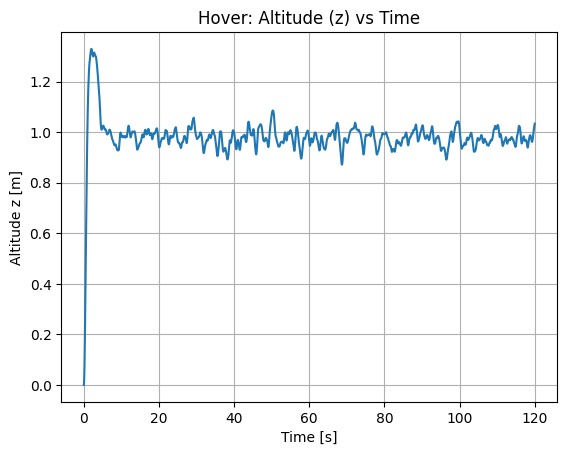

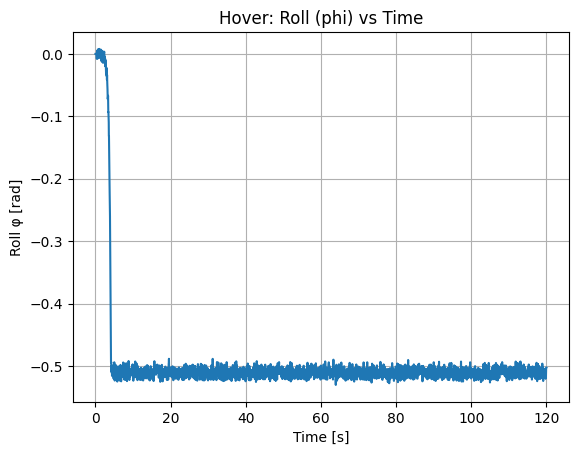

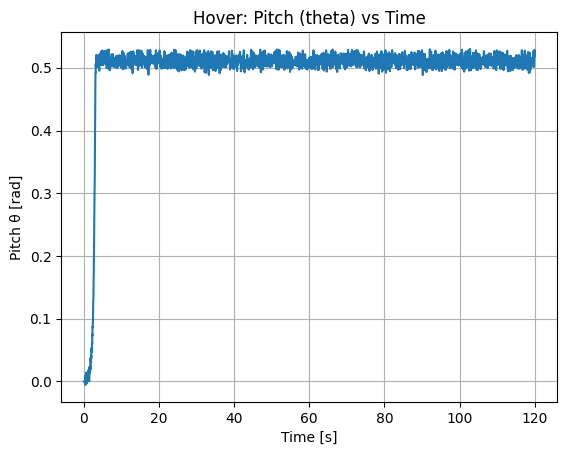

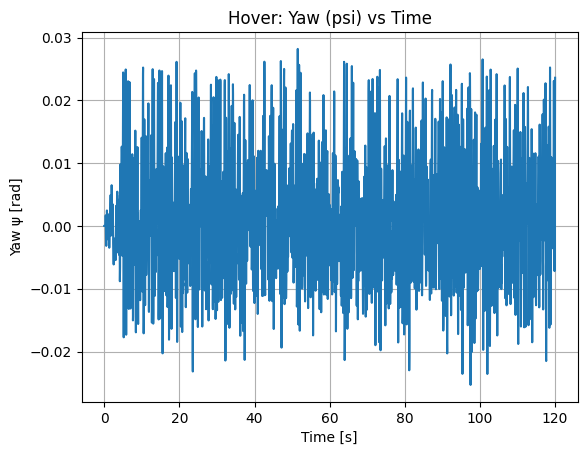

In [7]:
# Cell 2: Hover plots
import matplotlib.pyplot as plt
t_hover, y_hover = results['hover']

# positions and angles
z_h = y_hover[2]
phi_h = y_hover[6]; theta_h = y_hover[7]; psi_h = y_hover[8]

plt.figure()
plt.plot(t_hover, z_h)
plt.title('Hover: Altitude (z) vs Time')
plt.xlabel('Time [s]'); plt.ylabel('Altitude z [m]')
plt.grid(True)
plt.show()

plt.figure()
plt.plot(t_hover, phi_h)
plt.title('Hover: Roll (phi) vs Time')
plt.xlabel('Time [s]'); plt.ylabel('Roll φ [rad]')
plt.grid(True)
plt.show()

plt.figure()
plt.plot(t_hover, theta_h)
plt.title('Hover: Pitch (theta) vs Time')
plt.xlabel('Time [s]'); plt.ylabel('Pitch θ [rad]')
plt.grid(True)
plt.show()

plt.figure()
plt.plot(t_hover, psi_h)
plt.title('Hover: Yaw (psi) vs Time')
plt.xlabel('Time [s]'); plt.ylabel('Yaw ψ [rad]')
plt.grid(True)
plt.show()


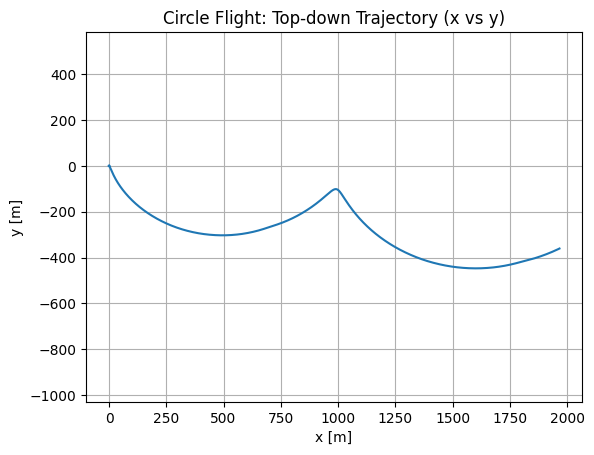

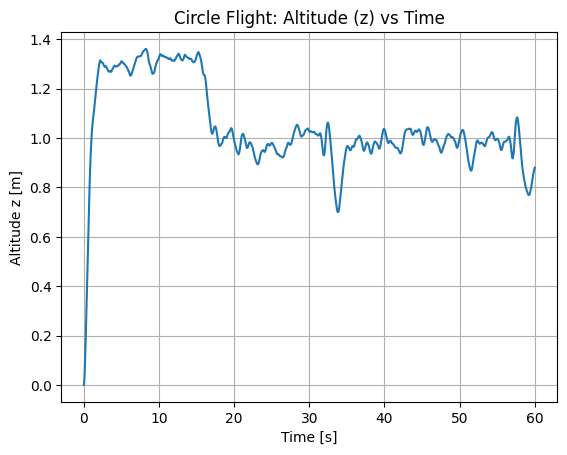

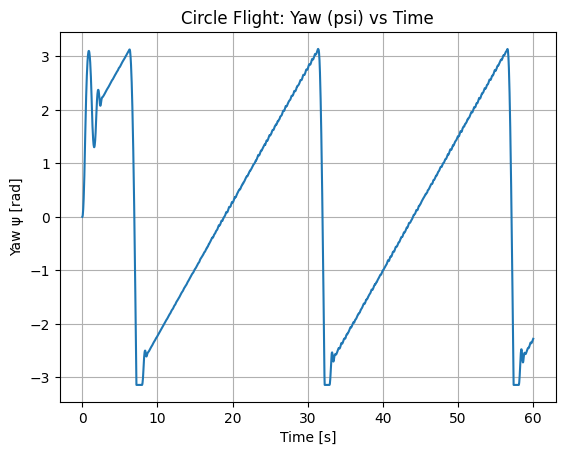

In [8]:
# Cell 3: Circle flight plots
import matplotlib.pyplot as plt
t_circle, y_circle = results['circle']

x_c = y_circle[0]; y_c = y_circle[1]; z_c = y_circle[2]
psi_c = y_circle[8]

plt.figure()
plt.plot(x_c, y_c)
plt.axis('equal')
plt.title('Circle Flight: Top-down Trajectory (x vs y)')
plt.xlabel('x [m]'); plt.ylabel('y [m]')
plt.grid(True)
plt.show()

plt.figure()
plt.plot(t_circle, z_c)
plt.title('Circle Flight: Altitude (z) vs Time')
plt.xlabel('Time [s]'); plt.ylabel('Altitude z [m]')
plt.grid(True)
plt.show()

plt.figure()
plt.plot(t_circle, psi_c)
plt.title('Circle Flight: Yaw (psi) vs Time')
plt.xlabel('Time [s]'); plt.ylabel('Yaw ψ [rad]')
plt.grid(True)
plt.show()


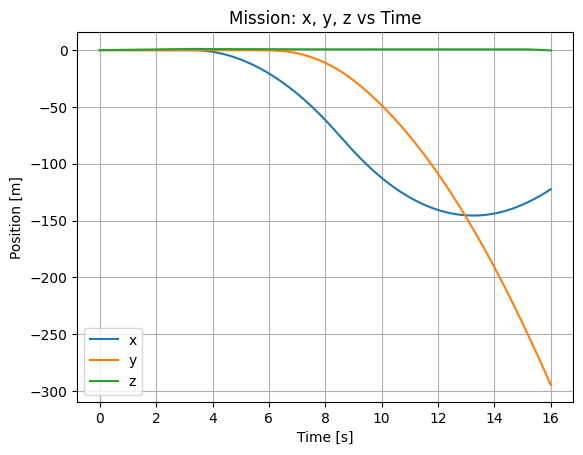

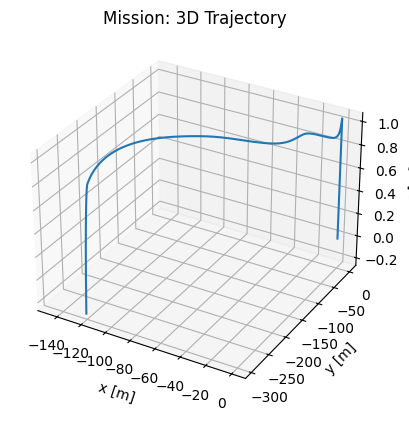

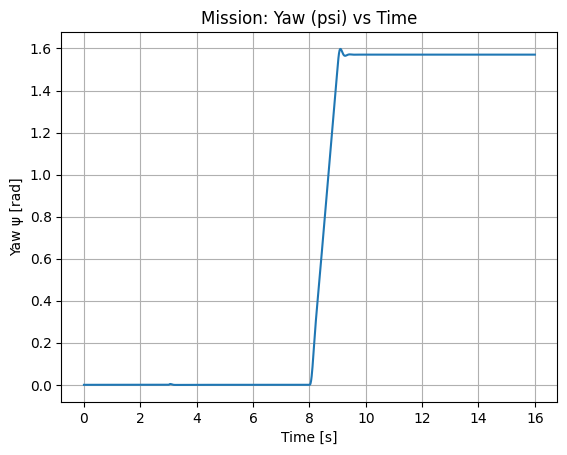

In [9]:
# Cell 4: Mission sequence plots
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
t_mission, y_mission = results['mission']

x_m = y_mission[0]; y_m = y_mission[1]; z_m = y_mission[2]; psi_m = y_mission[8]

plt.figure()
plt.plot(t_mission, x_m, label='x')
plt.plot(t_mission, y_m, label='y')
plt.plot(t_mission, z_m, label='z')
plt.title('Mission: x, y, z vs Time')
plt.xlabel('Time [s]'); plt.ylabel('Position [m]')
plt.legend()
plt.grid(True)
plt.show()

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(x_m, y_m, z_m)
ax.set_title('Mission: 3D Trajectory')
ax.set_xlabel('x [m]'); ax.set_ylabel('y [m]'); ax.set_zlabel('z [m]')
plt.show()

plt.figure()
plt.plot(t_mission, psi_m)
plt.title('Mission: Yaw (psi) vs Time')
plt.xlabel('Time [s]'); plt.ylabel('Yaw ψ [rad]')
plt.grid(True)
plt.show()
#blabha lbhalbfkdj